/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Final success rate of Value Iteration: 73.0%


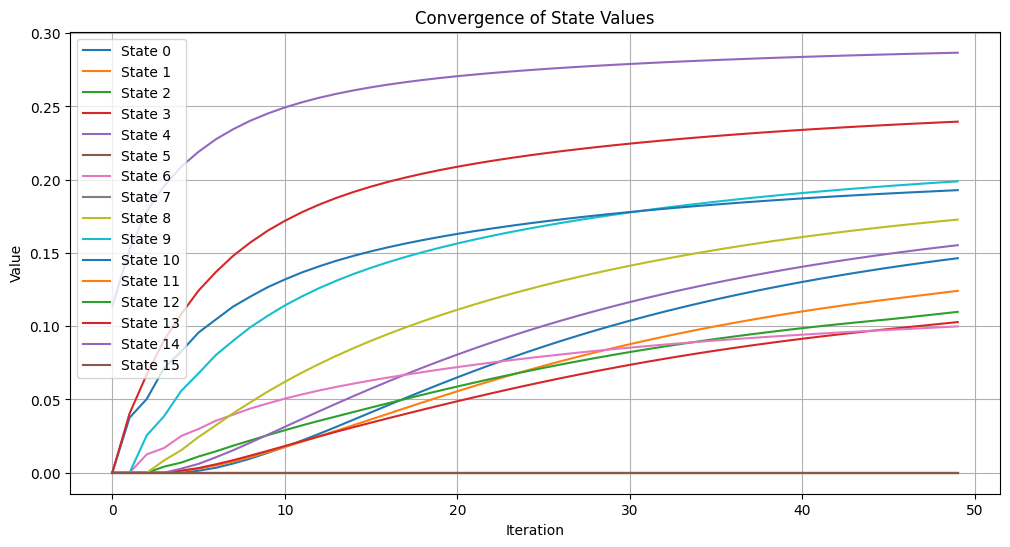

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt

def testPolicy(policy, trials=100):
# Function to test a policy in the environment
# Returns the success rate of the policy

    env = gym.make("FrozenLake-v1", is_slippery=True)
    env.reset()
    success = 0

    for _ in range(trials):
        done = False
        state = env.reset()
        while not done:
            action = policy[state]
            state, _, done, _ = env.step(action)
            if state == 15:  # Assumes a specific goal state index, adjust as needed
                success += 1

    avg_success_rate = success / trials
    return avg_success_rate

def learnModel(env, samples=1e5):
# Function to learn the transition probabilities and rewards from samples
# Returns transition probabilities and reward values

    num_state = env.observation_space.n
    num_action = env.action_space.n

    trans_prob = np.zeros((num_state, num_action, num_state))
    reward = np.zeros((num_state, num_action, num_state))

    for _ in range(int(samples)):
        state = env.reset()
        done = False

        while not done:
            random_action = env.action_space.sample()
            new_state, r, done, _ = env.step(random_action)
            trans_prob[state][random_action][new_state] += 1
            reward[state][random_action][new_state] += r
            state = new_state

    for s in range(num_state):
        for a in range(num_action):
            norm_sum = np.sum(trans_prob[s][a])
            if norm_sum > 0:
                trans_prob[s][a] /= norm_sum
                reward[s][a] /= norm_sum

    return trans_prob, reward

def valueItr(trans_prob, reward, gamma=0.99, max_itr=100):
# Value iteration algorithm to find optimal policy
# Returns optimal policy, success rate during iteration, and state values

    num_state = trans_prob.shape[0]
    num_action = trans_prob.shape[1]
    value = np.zeros(num_state)
    policy = np.zeros(num_state, dtype=int)
    success_rate = []
    state_values = []

    for _ in range(max_itr):
        new_value = np.zeros(num_state)
        for s in range(num_state):
            Q_values = [sum(trans_prob[s][a][s_new] * (reward[s][a][s_new] + gamma * value[s_new]) for s_new in range(num_state)) for a in range(num_action)]
            new_value[s] = max(Q_values)
            policy[s] = np.argmax(Q_values)
        state_values.append(new_value.copy())

        success_rate.append(testPolicy(policy))
        if np.allclose(value, new_value, atol=1e-4):
            break
        value = new_value

    return policy, success_rate, state_values

def plot_state_values(state_values, title="Convergence of State Values"):
# Function to plot convergence of state values during value iteration

    plt.figure(figsize=(12, 6))
    for state_index in range(len(state_values[0])):
        plt.plot([values[state_index] for values in state_values], label=f"State {state_index}")
    plt.xlabel("Iteration")
    plt.ylabel("Value")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


if __name__ == "__main__":
# Main function to execute the code
# Creates FrozenLake environment, learns the model, performs value iteration,
# and plots the results

    env = gym.make("FrozenLake-v1", is_slippery=True)
    env.reset()

    trans_prob, reward = learnModel(env)

    VI_policy, VI_success_rate, VI_state_values = valueItr(trans_prob, reward, max_itr=50)
    print("Final success rate of Value Iteration: {:.1f}%".format(VI_success_rate[-1] * 100))
    plot_state_values(VI_state_values)